## setup

In [ ]:
import einops
import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import re
import time
import torch

from dataclasses import dataclass
from google.colab import drive
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tabulate import tabulate
from torch import Tensor
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from typing import Dict, List, Tuple

## utils

In [ ]:
# ==================
# function: set seed
# ==================
def set_seed(seed: int = 42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # for multi-GPU setups
    np.random.seed(seed)
    random.seed(seed)

    # ensures deterministic operations on GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False  # Disable benchmark mode


# ========================
# function: get directions
# ========================
def get_directions(
    linear_probe: Tensor,
    options: int,
    mappings: Dict[str, int],
    verbose: bool = True
    ) -> Dict[str, Tensor]:
    """
    extract directions (unnormalized) from linear probe
    """
    directions = linear_probe.detach().cpu().numpy()
    mapping = mappings["relation"]

    # create a mapping from class names to their weight vectors
    directions_dict = {}

    for relation, relation_index in mapping.items():
        if relation_index < options:
            directions_dict[relation] = directions[:, int(relation_index)]

    if verbose:
      for relation in mapping.items():
          print(f"shape of direction {relation[0]} vector (d_model,) = {directions_dict[relation[0]].shape}" if verbose else "")

    return directions_dict

## data utils

In [ ]:
# =========================
# function: parse sentences
# =========================
def parse_sentences(
    sentences: List[str],
    verbose: bool = True,
    num_sample_triplets: int = 100
) -> Dict[str, List]:
    """
    Parses sentences into structured triplets with precise relation extraction.
    """
    start_time = time.time()

    triplets = []
    valid_indices = []

    # Updated regex pattern to capture the full multi-word relation
    pattern = r"The\s+(.*?)\s+is\s+(.*)\s+the\s+(.*?)\."

    for i, sentence in enumerate(sentences):
        # decode the byte string to a regular string
        sentence = sentence.decode('utf-8')
        match = re.match(pattern, sentence, re.IGNORECASE)
        if match:
            obj1 = match.group(1).strip()
            relation = match.group(2).strip()
            obj2 = match.group(3).strip()
            triplets.append((obj1, relation, obj2))
            valid_indices.append(i)

    if verbose:
        print("\n=== triplets ===")
        for i in range(min(num_sample_triplets, len(triplets))):
            print(f"{i}: {triplets[i]}")

    return {
        "triplets": triplets,
        "valid_indices": valid_indices
    }


# =========================
# function: encode triplets
# =========================
def encode_triplets(
    triplets: List[Tuple[str, str, str]],
    verbose: bool = True
) -> Tuple[Dict[str, np.ndarray], Dict[str, Dict[str, int]]]:
    """
    encode triplets for model training
    """
    start_time = time.time()
    print("encoding triplets..." if verbose else "")

    # extract separate components
    objects1, relations, objects2 = zip(*triplets)

    # filter out empty strings
    objects1 = [obj if obj else "UNKNOWN" for obj in objects1]
    relations = [rel if rel else "UNKNOWN" for rel in relations]
    objects2 = [obj if obj else "UNKNOWN" for obj in objects2]

    # encode each component
    obj1_encoder = LabelEncoder()
    rel_encoder = LabelEncoder()
    obj2_encoder = LabelEncoder()

    obj1_labels = obj1_encoder.fit_transform(objects1)
    rel_labels = rel_encoder.fit_transform(relations)
    obj2_labels = obj2_encoder.fit_transform(objects2)

    labels = {"object_1": obj1_labels, "relation": rel_labels, "object_2": obj2_labels}

    # create mapping dictionaries for later analysis
    obj1_mapping = dict(zip(obj1_encoder.classes_, range(len(obj1_encoder.classes_))))
    rel_mapping = dict(zip(rel_encoder.classes_, range(len(rel_encoder.classes_))))
    obj2_mapping = dict(zip(obj2_encoder.classes_, range(len(obj2_encoder.classes_))))

    mappings = {"object_1": obj1_mapping, "relation": rel_mapping, "object_2": obj2_mapping}

    if verbose:
        print(f"found {len(obj1_mapping)} unique objects as subject")
        print(f"found {len(rel_mapping)} unique relations")
        print(f"found {len(obj2_mapping)} unique objects as object")

        # Print some of the unique relations
        print("\nrelations used:")
        sample_relations = list(rel_mapping.keys())
        for i, rel in enumerate(sample_relations):
            print(f"{i}: {rel}")

        print(f"encoding completed in {time.time() - start_time:.2f} seconds")

    return labels, mappings


# ============================
# function: prepare data split
# ============================
def prepare_data_split(layer_data: torch.Tensor, valid_indices: List[int], labels: Dict[str, np.ndarray], test_size: float=0.2) -> Dict[str, torch.Tensor]:
    """
    prepare single train/test split for all labels
    """
    # filter embeddings to keep only valid indices
    X = layer_data[valid_indices]

    # create a single train/test split for all labels
    X_train, X_test, y_rel_train, y_rel_test = train_test_split(
        X,
        labels["relation"],
        test_size=test_size,
        random_state=42
        )

    # convert to PyTorch tensors
    X_train_tensor = X_train.clone().detach().float()
    X_test_tensor = X_test.clone().detach().float()

    y_rel_train_tensor = torch.tensor(y_rel_train, dtype=torch.long)
    y_rel_test_tensor = torch.tensor(y_rel_test, dtype=torch.long)

    return {
        'X_train': X_train_tensor,
        'X_test': X_test_tensor,
        'y_rel_train': y_rel_train_tensor,
        'y_rel_test': y_rel_test_tensor,
        }

# =============================
# function: create data loaders
# =============================
def create_data_loaders(split_data: Dict[str, torch.Tensor], batch_size: int=256) -> Dict[str, Dict[str, TensorDataset]]:
    """
    create data loaders for training and testing
    """
    # create training dataset
    train_rel_dataset = TensorDataset(split_data['X_train'], split_data['y_rel_train'])

    # create test dataset
    test_rel_dataset = TensorDataset(split_data['X_test'], split_data['y_rel_test'])

    # create data loaders
    train_rel_loader = DataLoader(train_rel_dataset, batch_size=batch_size, shuffle=True)
    test_rel_loader = DataLoader(test_rel_dataset, batch_size=batch_size)

    return {
        'train': {
            'relation': train_rel_loader,
            },
        'test': {
            'relation': test_rel_loader,
            }
        }

## linear probes

In [ ]:
# ============================
# class: probe train arguments
# ============================
@dataclass
class ProbeTrainingArgs:
    verbose: bool = False
    device: torch.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # layer information
    layer_name: str = "layer_8"

    # spatial relation state
    options: int = 4
    d_model: int = 3072

    # standard training hyperparams
    epochs: int = 10

    # hyperparams for optimizer
    lr: float = 1e-3

    # cpde to get randomly initialized probe
    def setup_probe(self) -> torch.Tensor:
        linear_probe = torch.randn(self.d_model, self.options, device=self.device) / np.sqrt(self.d_model)
        linear_probe.requires_grad = True
        print(f"shape of linear probe is: d_model = {linear_probe.shape[0]} and options = {linear_probe.shape[-1]}" if self.verbose else "")
        return linear_probe


# ===========================
# class: Linear probe trainer
# ===========================
class LinearProbeTrainer:
    def __init__(self, args: ProbeTrainingArgs, dataloader: torch.utils.data.DataLoader):
        self.args = args
        self.linear_probe = args.setup_probe()
        self.dataloader = dataloader

    def train(self):
        if self.args.verbose:
            print(f"\ntraining a linear probe for spatial relations of layer {self.args.layer_name} for {self.args.epochs} epochs ...\n")
        self.step = 0

        # define optimizer
        optimizer = torch.optim.Adam(
            [self.linear_probe], lr=self.args.lr
        )

        # define loss criterion
        criterion = torch.nn.CrossEntropyLoss()

        for epoch in range(self.args.epochs):
            total_loss = 0
            correct = 0
            total = 0

            for inputs, targets in tqdm(self.dataloader, desc=f"Epoch {epoch+1}/{self.args.epochs}"):

                # move data to device
                inputs, targets = inputs.to(self.args.device), targets.to(self.args.device)

                # get probe output
                probe_preds = einops.einsum(
                    inputs,
                    self.linear_probe,
                    "batch d_model, d_model options -> batch options",
                    )

                # compute loss
                loss = criterion(probe_preds, targets)

                # optimize
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

                # update loss and accuracy
                total_loss += loss.item()
                _, predicted = torch.max(probe_preds.data, 1)
                total += targets.size(0)
                correct += (predicted == targets).sum().item()

            # print epoch results
            avg_loss = total_loss / len(self.dataloader)
            accuracy = 100 * correct / total
            print(f"Epoch {epoch+1}/{self.args.epochs}: Loss={avg_loss:.4f}, Accuracy={accuracy:.2f}%")

# ========================
# function: evaluate probe
# ========================
def evaluate_probe(linear_probe: torch.Tensor, dataloader: DataLoader, device=torch.device("cuda" if torch.cuda.is_available() else "cpu")):
    """
    evaluate a linear probe model
    """
    all_preds = []
    all_targets = []

    with torch.inference_mode():
        for inputs, targets in dataloader:

            # move data to device
            inputs, targets = inputs.to(device), targets.to(device)

            # get linear probe preds
            probe_preds = einops.einsum(
                inputs,
                linear_probe,
                "batch d_model, d_model options -> batch options",
                )
            _, predicted = torch.max(probe_preds, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    accuracy = accuracy_score(all_targets, all_preds)
    report = classification_report(all_targets, all_preds, output_dict=True, zero_division=1)

    return accuracy, report

## main

In [ ]:
# mount google drive
drive.mount('/content/drive')

# config variables
VERBOSE = True
selected_layer: int = 24

# define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"we are using {device}" if VERBOSE else "")

# seet rng seed
set_seed(1234)

# define the dataset name
# dataset_path = "drive/MyDrive/datasets-sentences/simple_3D_250920_sentences.h5"
dataset_path = "drive/MyDrive/simple_3D_516852_sentences.h5"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
we are using cuda


In [ ]:
# load the data
dataset = h5py.File(dataset_path, 'r')

# list the datasets (for example, "sentences" and possibly an "embeddings" group)
print(list(dataset.keys()))

# define sentences and embeddings
sentences = dataset['sentences']
embeddings = dataset['embeddings']
# layers_list = [8, 16, 24]
layers_list = [16, 24]         # for 500k data, we only have the 16th and 24th layers


if VERBOSE:
    print("\n" + "=" * 40)
    print("📊 dataset and embedding statistics")
    print("=" * 40)

    # dataset statistics
    print(f"\n🔢 dataset overview:")
    print(f"• total sentences: {len(sentences):,}")

    # layer details
    print(f"\n🧬 embedding layers extracted:")
    for k in layers_list:
        layer_name = f"layer_{k}"
        layer_shape = embeddings[layer_name].shape
        print(f"• layer {k}: shape: {layer_shape}")
    print("\n" + "=" * 40)

['embeddings', 'sentences']

📊 dataset and embedding statistics

🔢 dataset overview:
• total sentences: 516,852

🧬 embedding layers extracted:
• layer 16: shape: (516852, 3072)
• layer 24: shape: (516852, 3072)



### training linear probes for 3D

In [ ]:
# transform data to torch
layers_tensors = {}
for k in layers_list:
    layer_name = f"layer_{k}"
    layers_tensors[layer_name] = torch.tensor(embeddings[layer_name][:])
    print(f"layer {k} embeddings shape (# sentences, d_model): {layers_tensors[layer_name].shape}" if VERBOSE else "")

layer 16 embeddings shape (# sentences, d_model): torch.Size([516852, 3072])
layer 24 embeddings shape (# sentences, d_model): torch.Size([516852, 3072])


In [ ]:
# parse senteces
pars_sentences = parse_sentences(sentences, verbose=VERBOSE, num_sample_triplets=20)


=== triplets ===
0: ('pen', 'above', 'pencil')
1: ('pen', 'below', 'pencil')
2: ('pen', 'to the right of', 'pencil')
3: ('pen', 'to the left of', 'pencil')
4: ('pen', 'in front of', 'pencil')
5: ('pen', 'behind', 'pencil')
6: ('pen', 'above', 'eraser')
7: ('pen', 'below', 'eraser')
8: ('pen', 'to the right of', 'eraser')
9: ('pen', 'to the left of', 'eraser')
10: ('pen', 'in front of', 'eraser')
11: ('pen', 'behind', 'eraser')
12: ('pen', 'above', 'notebook')
13: ('pen', 'below', 'notebook')
14: ('pen', 'to the right of', 'notebook')
15: ('pen', 'to the left of', 'notebook')
16: ('pen', 'in front of', 'notebook')
17: ('pen', 'behind', 'notebook')
18: ('pen', 'above', 'paper')
19: ('pen', 'below', 'paper')


In [ ]:
# encode triplets
labels, mappings = encode_triplets(pars_sentences["triplets"], verbose=VERBOSE)

encoding triplets...
found 293 unique objects as subject
found 6 unique relations
found 293 unique objects as object

relations used:
0: above
1: behind
2: below
3: in front of
4: to the left of
5: to the right of
encoding completed in 1.64 seconds


In [ ]:
# prepare layer data for split
batch_size = {}
dataloaders = {}
test_size = 0.2

# get number of relations
options = len(mappings["relation"])
print(f"number of unique relations: {options}" if VERBOSE else "")

for k in layers_list:
    layer_name = f"layer_{k}"
    batch_size[layer_name], d_model = layers_tensors[layer_name].shape
    print(f"layer data shape (num, d_model): {layers_tensors[layer_name].shape}" if VERBOSE else "")

    # create dataloaders
    split_data = prepare_data_split(layers_tensors[layer_name], pars_sentences["valid_indices"], labels, test_size=test_size)
    dataloaders[layer_name] = create_data_loaders(split_data, batch_size=1024)

number of unique relations: 6
layer data shape (num, d_model): torch.Size([516852, 3072])
layer data shape (num, d_model): torch.Size([516852, 3072])


In [ ]:
# train the linear probe
torch.set_grad_enabled(True)
args = {}
trainers = {}

for k in layers_list:
    layer_name = f"layer_{k}"
    args[layer_name] = ProbeTrainingArgs(
        d_model=d_model,
        options=options,
        layer_name=layer_name,
        epochs=100,
        lr=1e-3,
        verbose=VERBOSE
        )

    trainers[layer_name] = LinearProbeTrainer(args[layer_name], dataloader=dataloaders[layer_name]["train"]["relation"])      # we focus only on the spatial relation
    trainers[layer_name].train()

shape of linear probe is: d_model = 3072 and options = 6

training a linear probe for spatial relations of layer layer_16 for 100 epochs ...



Epoch 1/100: 100%|██████████| 404/404 [00:06<00:00, 59.06it/s]


Epoch 1/100: Loss=0.1530, Accuracy=97.91%


Epoch 2/100: 100%|██████████| 404/404 [00:06<00:00, 62.31it/s]


Epoch 2/100: Loss=0.0234, Accuracy=99.90%


Epoch 3/100: 100%|██████████| 404/404 [00:06<00:00, 65.58it/s]


Epoch 3/100: Loss=0.0119, Accuracy=99.96%


Epoch 4/100: 100%|██████████| 404/404 [00:06<00:00, 63.93it/s]


Epoch 4/100: Loss=0.0075, Accuracy=99.98%


Epoch 5/100: 100%|██████████| 404/404 [00:06<00:00, 66.07it/s]


Epoch 5/100: Loss=0.0051, Accuracy=99.99%


Epoch 6/100: 100%|██████████| 404/404 [00:06<00:00, 64.81it/s]


Epoch 6/100: Loss=0.0038, Accuracy=99.99%


Epoch 7/100: 100%|██████████| 404/404 [00:05<00:00, 67.69it/s]


Epoch 7/100: Loss=0.0028, Accuracy=99.99%


Epoch 8/100: 100%|██████████| 404/404 [00:06<00:00, 65.09it/s]


Epoch 8/100: Loss=0.0022, Accuracy=100.00%


Epoch 9/100: 100%|██████████| 404/404 [00:06<00:00, 67.16it/s]


Epoch 9/100: Loss=0.0018, Accuracy=100.00%


Epoch 10/100: 100%|██████████| 404/404 [00:05<00:00, 69.24it/s]


Epoch 10/100: Loss=0.0014, Accuracy=100.00%


Epoch 11/100: 100%|██████████| 404/404 [00:06<00:00, 66.43it/s]


Epoch 11/100: Loss=0.0012, Accuracy=100.00%


Epoch 12/100: 100%|██████████| 404/404 [00:05<00:00, 68.72it/s]


Epoch 12/100: Loss=0.0009, Accuracy=100.00%


Epoch 13/100: 100%|██████████| 404/404 [00:06<00:00, 65.98it/s]


Epoch 13/100: Loss=0.0008, Accuracy=100.00%


Epoch 14/100: 100%|██████████| 404/404 [00:05<00:00, 68.38it/s]


Epoch 14/100: Loss=0.0006, Accuracy=100.00%


Epoch 15/100: 100%|██████████| 404/404 [00:06<00:00, 65.81it/s]


Epoch 15/100: Loss=0.0005, Accuracy=100.00%


Epoch 16/100: 100%|██████████| 404/404 [00:05<00:00, 69.38it/s]


Epoch 16/100: Loss=0.0005, Accuracy=100.00%


Epoch 17/100: 100%|██████████| 404/404 [00:06<00:00, 66.69it/s]


Epoch 17/100: Loss=0.0004, Accuracy=100.00%


Epoch 18/100: 100%|██████████| 404/404 [00:05<00:00, 68.32it/s]


Epoch 18/100: Loss=0.0003, Accuracy=100.00%


Epoch 19/100: 100%|██████████| 404/404 [00:06<00:00, 66.74it/s]


Epoch 19/100: Loss=0.0003, Accuracy=100.00%


Epoch 20/100: 100%|██████████| 404/404 [00:05<00:00, 68.59it/s]


Epoch 20/100: Loss=0.0002, Accuracy=100.00%


Epoch 21/100: 100%|██████████| 404/404 [00:06<00:00, 65.93it/s]


Epoch 21/100: Loss=0.0002, Accuracy=100.00%


Epoch 22/100: 100%|██████████| 404/404 [00:06<00:00, 67.03it/s]


Epoch 22/100: Loss=0.0002, Accuracy=100.00%


Epoch 23/100: 100%|██████████| 404/404 [00:06<00:00, 65.97it/s]


Epoch 23/100: Loss=0.0001, Accuracy=100.00%


Epoch 24/100: 100%|██████████| 404/404 [00:06<00:00, 66.44it/s]


Epoch 24/100: Loss=0.0001, Accuracy=100.00%


Epoch 25/100: 100%|██████████| 404/404 [00:06<00:00, 65.98it/s]


Epoch 25/100: Loss=0.0001, Accuracy=100.00%


Epoch 26/100: 100%|██████████| 404/404 [00:06<00:00, 65.24it/s]


Epoch 26/100: Loss=0.0001, Accuracy=100.00%


Epoch 27/100: 100%|██████████| 404/404 [00:06<00:00, 67.15it/s]


Epoch 27/100: Loss=0.0001, Accuracy=100.00%


Epoch 28/100: 100%|██████████| 404/404 [00:06<00:00, 65.48it/s]


Epoch 28/100: Loss=0.0001, Accuracy=100.00%


Epoch 29/100: 100%|██████████| 404/404 [00:05<00:00, 67.77it/s]


Epoch 29/100: Loss=0.0001, Accuracy=100.00%


Epoch 30/100: 100%|██████████| 404/404 [00:06<00:00, 66.60it/s]


Epoch 30/100: Loss=0.0000, Accuracy=100.00%


Epoch 31/100: 100%|██████████| 404/404 [00:05<00:00, 69.49it/s]


Epoch 31/100: Loss=0.0000, Accuracy=100.00%


Epoch 32/100: 100%|██████████| 404/404 [00:06<00:00, 65.50it/s]


Epoch 32/100: Loss=0.0000, Accuracy=100.00%


Epoch 33/100: 100%|██████████| 404/404 [00:05<00:00, 67.61it/s]


Epoch 33/100: Loss=0.0000, Accuracy=100.00%


Epoch 34/100: 100%|██████████| 404/404 [00:06<00:00, 65.83it/s]


Epoch 34/100: Loss=0.0000, Accuracy=100.00%


Epoch 35/100: 100%|██████████| 404/404 [00:05<00:00, 69.23it/s]


Epoch 35/100: Loss=0.0000, Accuracy=100.00%


Epoch 36/100: 100%|██████████| 404/404 [00:06<00:00, 65.56it/s]


Epoch 36/100: Loss=0.0000, Accuracy=100.00%


Epoch 37/100: 100%|██████████| 404/404 [00:05<00:00, 69.96it/s]


Epoch 37/100: Loss=0.0000, Accuracy=100.00%


Epoch 38/100: 100%|██████████| 404/404 [00:06<00:00, 65.28it/s]


Epoch 38/100: Loss=0.0000, Accuracy=100.00%


Epoch 39/100: 100%|██████████| 404/404 [00:05<00:00, 69.90it/s]


Epoch 39/100: Loss=0.0000, Accuracy=100.00%


Epoch 40/100: 100%|██████████| 404/404 [00:06<00:00, 67.23it/s]


Epoch 40/100: Loss=0.0000, Accuracy=100.00%


Epoch 41/100: 100%|██████████| 404/404 [00:05<00:00, 69.46it/s]


Epoch 41/100: Loss=0.0000, Accuracy=100.00%


Epoch 42/100: 100%|██████████| 404/404 [00:06<00:00, 66.42it/s]


Epoch 42/100: Loss=0.0000, Accuracy=100.00%


Epoch 43/100: 100%|██████████| 404/404 [00:06<00:00, 66.52it/s]


Epoch 43/100: Loss=0.0000, Accuracy=100.00%


Epoch 44/100: 100%|██████████| 404/404 [00:05<00:00, 68.94it/s]


Epoch 44/100: Loss=0.0000, Accuracy=100.00%


Epoch 45/100: 100%|██████████| 404/404 [00:06<00:00, 66.40it/s]


Epoch 45/100: Loss=0.0000, Accuracy=100.00%


Epoch 46/100: 100%|██████████| 404/404 [00:05<00:00, 68.66it/s]


Epoch 46/100: Loss=0.0000, Accuracy=100.00%


Epoch 47/100: 100%|██████████| 404/404 [00:06<00:00, 66.16it/s]


Epoch 47/100: Loss=0.0000, Accuracy=100.00%


Epoch 48/100: 100%|██████████| 404/404 [00:05<00:00, 68.39it/s]


Epoch 48/100: Loss=0.0000, Accuracy=100.00%


Epoch 49/100: 100%|██████████| 404/404 [00:06<00:00, 66.63it/s]


Epoch 49/100: Loss=0.0000, Accuracy=100.00%


Epoch 50/100: 100%|██████████| 404/404 [00:05<00:00, 69.32it/s]


Epoch 50/100: Loss=0.0000, Accuracy=100.00%


Epoch 51/100: 100%|██████████| 404/404 [00:06<00:00, 67.03it/s]


Epoch 51/100: Loss=0.0000, Accuracy=100.00%


Epoch 52/100: 100%|██████████| 404/404 [00:05<00:00, 68.31it/s]


Epoch 52/100: Loss=0.0000, Accuracy=100.00%


Epoch 53/100: 100%|██████████| 404/404 [00:06<00:00, 64.86it/s]


Epoch 53/100: Loss=0.0000, Accuracy=100.00%


Epoch 54/100: 100%|██████████| 404/404 [00:06<00:00, 66.94it/s]


Epoch 54/100: Loss=0.0000, Accuracy=100.00%


Epoch 55/100: 100%|██████████| 404/404 [00:06<00:00, 65.22it/s]


Epoch 55/100: Loss=0.0000, Accuracy=100.00%


Epoch 56/100: 100%|██████████| 404/404 [00:06<00:00, 67.17it/s]


Epoch 56/100: Loss=0.0000, Accuracy=100.00%


Epoch 57/100: 100%|██████████| 404/404 [00:06<00:00, 65.26it/s]


Epoch 57/100: Loss=0.0000, Accuracy=100.00%


Epoch 58/100: 100%|██████████| 404/404 [00:05<00:00, 68.03it/s]


Epoch 58/100: Loss=0.0000, Accuracy=100.00%


Epoch 59/100: 100%|██████████| 404/404 [00:06<00:00, 66.31it/s]


Epoch 59/100: Loss=0.0000, Accuracy=100.00%


Epoch 60/100: 100%|██████████| 404/404 [00:05<00:00, 68.72it/s]


Epoch 60/100: Loss=0.0000, Accuracy=100.00%


Epoch 61/100: 100%|██████████| 404/404 [00:06<00:00, 66.43it/s]


Epoch 61/100: Loss=0.0000, Accuracy=100.00%


Epoch 62/100: 100%|██████████| 404/404 [00:05<00:00, 69.21it/s]


Epoch 62/100: Loss=0.0000, Accuracy=100.00%


Epoch 63/100: 100%|██████████| 404/404 [00:06<00:00, 66.30it/s]


Epoch 63/100: Loss=0.0000, Accuracy=100.00%


Epoch 64/100: 100%|██████████| 404/404 [00:05<00:00, 68.53it/s]


Epoch 64/100: Loss=0.0000, Accuracy=100.00%


Epoch 65/100: 100%|██████████| 404/404 [00:06<00:00, 66.03it/s]


Epoch 65/100: Loss=0.0000, Accuracy=100.00%


Epoch 66/100: 100%|██████████| 404/404 [00:06<00:00, 66.51it/s]


Epoch 66/100: Loss=0.0000, Accuracy=100.00%


Epoch 67/100: 100%|██████████| 404/404 [00:05<00:00, 69.42it/s]


Epoch 67/100: Loss=0.0000, Accuracy=100.00%


Epoch 68/100: 100%|██████████| 404/404 [00:06<00:00, 66.35it/s]


Epoch 68/100: Loss=0.0000, Accuracy=100.00%


Epoch 69/100: 100%|██████████| 404/404 [00:05<00:00, 68.74it/s]


Epoch 69/100: Loss=0.0000, Accuracy=100.00%


Epoch 70/100: 100%|██████████| 404/404 [00:06<00:00, 65.83it/s]


Epoch 70/100: Loss=0.0000, Accuracy=100.00%


Epoch 71/100: 100%|██████████| 404/404 [00:05<00:00, 70.03it/s]


Epoch 71/100: Loss=0.0000, Accuracy=100.00%


Epoch 72/100: 100%|██████████| 404/404 [00:06<00:00, 67.00it/s]


Epoch 72/100: Loss=0.0000, Accuracy=100.00%


Epoch 73/100: 100%|██████████| 404/404 [00:06<00:00, 67.16it/s]


Epoch 73/100: Loss=0.0000, Accuracy=100.00%


Epoch 74/100: 100%|██████████| 404/404 [00:06<00:00, 66.04it/s]


Epoch 74/100: Loss=0.0000, Accuracy=100.00%


Epoch 75/100: 100%|██████████| 404/404 [00:05<00:00, 69.23it/s]


Epoch 75/100: Loss=0.0000, Accuracy=100.00%


Epoch 76/100: 100%|██████████| 404/404 [00:06<00:00, 66.70it/s]


Epoch 76/100: Loss=0.0000, Accuracy=100.00%


Epoch 77/100: 100%|██████████| 404/404 [00:05<00:00, 68.39it/s]


Epoch 77/100: Loss=0.0000, Accuracy=100.00%


Epoch 78/100: 100%|██████████| 404/404 [00:06<00:00, 65.11it/s]


Epoch 78/100: Loss=0.0000, Accuracy=100.00%


Epoch 79/100: 100%|██████████| 404/404 [00:05<00:00, 67.55it/s]


Epoch 79/100: Loss=0.0000, Accuracy=100.00%


Epoch 80/100: 100%|██████████| 404/404 [00:06<00:00, 64.27it/s]


Epoch 80/100: Loss=0.0000, Accuracy=100.00%


Epoch 81/100: 100%|██████████| 404/404 [00:05<00:00, 67.39it/s]


Epoch 81/100: Loss=0.0000, Accuracy=100.00%


Epoch 82/100: 100%|██████████| 404/404 [00:06<00:00, 66.78it/s]


Epoch 82/100: Loss=0.0000, Accuracy=100.00%


Epoch 83/100: 100%|██████████| 404/404 [00:06<00:00, 66.14it/s]


Epoch 83/100: Loss=0.0000, Accuracy=100.00%


Epoch 84/100: 100%|██████████| 404/404 [00:05<00:00, 67.51it/s]


Epoch 84/100: Loss=0.0000, Accuracy=100.00%


Epoch 85/100: 100%|██████████| 404/404 [00:06<00:00, 67.29it/s]


Epoch 85/100: Loss=0.0000, Accuracy=100.00%


Epoch 86/100: 100%|██████████| 404/404 [00:05<00:00, 68.42it/s]


Epoch 86/100: Loss=0.0000, Accuracy=100.00%


Epoch 87/100: 100%|██████████| 404/404 [00:06<00:00, 67.20it/s]


Epoch 87/100: Loss=0.0000, Accuracy=100.00%


Epoch 88/100: 100%|██████████| 404/404 [00:05<00:00, 67.58it/s]


Epoch 88/100: Loss=0.0000, Accuracy=100.00%


Epoch 89/100: 100%|██████████| 404/404 [00:06<00:00, 66.48it/s]


Epoch 89/100: Loss=0.0000, Accuracy=100.00%


Epoch 90/100: 100%|██████████| 404/404 [00:05<00:00, 67.66it/s]


Epoch 90/100: Loss=0.0000, Accuracy=100.00%


Epoch 91/100: 100%|██████████| 404/404 [00:06<00:00, 66.71it/s]


Epoch 91/100: Loss=0.0000, Accuracy=100.00%


Epoch 92/100: 100%|██████████| 404/404 [00:05<00:00, 68.17it/s]


Epoch 92/100: Loss=0.0000, Accuracy=100.00%


Epoch 93/100: 100%|██████████| 404/404 [00:06<00:00, 67.31it/s]


Epoch 93/100: Loss=0.0000, Accuracy=100.00%


Epoch 94/100: 100%|██████████| 404/404 [00:06<00:00, 67.08it/s]


Epoch 94/100: Loss=0.0000, Accuracy=100.00%


Epoch 95/100: 100%|██████████| 404/404 [00:06<00:00, 66.42it/s]


Epoch 95/100: Loss=0.0000, Accuracy=100.00%


Epoch 96/100: 100%|██████████| 404/404 [00:06<00:00, 66.90it/s]


Epoch 96/100: Loss=0.0000, Accuracy=100.00%


Epoch 97/100: 100%|██████████| 404/404 [00:06<00:00, 65.00it/s]


Epoch 97/100: Loss=0.0000, Accuracy=100.00%


Epoch 98/100: 100%|██████████| 404/404 [00:06<00:00, 64.77it/s]


Epoch 98/100: Loss=0.0000, Accuracy=100.00%


Epoch 99/100: 100%|██████████| 404/404 [00:05<00:00, 69.79it/s]


Epoch 99/100: Loss=0.0000, Accuracy=100.00%


Epoch 100/100: 100%|██████████| 404/404 [00:06<00:00, 65.39it/s]


Epoch 100/100: Loss=0.0000, Accuracy=100.00%
shape of linear probe is: d_model = 3072 and options = 6

training a linear probe for spatial relations of layer layer_24 for 100 epochs ...



Epoch 1/100: 100%|██████████| 404/404 [00:05<00:00, 68.85it/s]


Epoch 1/100: Loss=0.1340, Accuracy=97.71%


Epoch 2/100: 100%|██████████| 404/404 [00:06<00:00, 65.60it/s]


Epoch 2/100: Loss=0.0181, Accuracy=99.95%


Epoch 3/100: 100%|██████████| 404/404 [00:05<00:00, 68.36it/s]


Epoch 3/100: Loss=0.0089, Accuracy=99.98%


Epoch 4/100: 100%|██████████| 404/404 [00:06<00:00, 66.55it/s]


Epoch 4/100: Loss=0.0056, Accuracy=99.98%


Epoch 5/100: 100%|██████████| 404/404 [00:05<00:00, 69.77it/s]


Epoch 5/100: Loss=0.0038, Accuracy=99.99%


Epoch 6/100: 100%|██████████| 404/404 [00:06<00:00, 66.96it/s]


Epoch 6/100: Loss=0.0028, Accuracy=99.99%


Epoch 7/100: 100%|██████████| 404/404 [00:05<00:00, 69.77it/s]


Epoch 7/100: Loss=0.0021, Accuracy=99.99%


Epoch 8/100: 100%|██████████| 404/404 [00:06<00:00, 66.15it/s]


Epoch 8/100: Loss=0.0016, Accuracy=100.00%


Epoch 9/100: 100%|██████████| 404/404 [00:05<00:00, 69.91it/s]


Epoch 9/100: Loss=0.0013, Accuracy=100.00%


Epoch 10/100: 100%|██████████| 404/404 [00:06<00:00, 67.07it/s]


Epoch 10/100: Loss=0.0010, Accuracy=100.00%


Epoch 11/100: 100%|██████████| 404/404 [00:05<00:00, 67.80it/s]


Epoch 11/100: Loss=0.0009, Accuracy=100.00%


Epoch 12/100: 100%|██████████| 404/404 [00:06<00:00, 66.30it/s]


Epoch 12/100: Loss=0.0007, Accuracy=100.00%


Epoch 13/100: 100%|██████████| 404/404 [00:05<00:00, 69.40it/s]


Epoch 13/100: Loss=0.0006, Accuracy=100.00%


Epoch 14/100: 100%|██████████| 404/404 [00:06<00:00, 67.06it/s]


Epoch 14/100: Loss=0.0005, Accuracy=100.00%


Epoch 15/100: 100%|██████████| 404/404 [00:06<00:00, 67.15it/s]


Epoch 15/100: Loss=0.0004, Accuracy=100.00%


Epoch 16/100: 100%|██████████| 404/404 [00:05<00:00, 68.47it/s]


Epoch 16/100: Loss=0.0003, Accuracy=100.00%


Epoch 17/100: 100%|██████████| 404/404 [00:06<00:00, 66.32it/s]


Epoch 17/100: Loss=0.0003, Accuracy=100.00%


Epoch 18/100: 100%|██████████| 404/404 [00:05<00:00, 69.18it/s]


Epoch 18/100: Loss=0.0002, Accuracy=100.00%


Epoch 19/100: 100%|██████████| 404/404 [00:05<00:00, 67.42it/s]


Epoch 19/100: Loss=0.0002, Accuracy=100.00%


Epoch 20/100: 100%|██████████| 404/404 [00:05<00:00, 68.38it/s]


Epoch 20/100: Loss=0.0002, Accuracy=100.00%


Epoch 21/100: 100%|██████████| 404/404 [00:05<00:00, 67.66it/s]


Epoch 21/100: Loss=0.0001, Accuracy=100.00%


Epoch 22/100: 100%|██████████| 404/404 [00:05<00:00, 69.87it/s]


Epoch 22/100: Loss=0.0001, Accuracy=100.00%


Epoch 23/100: 100%|██████████| 404/404 [00:05<00:00, 68.13it/s]


Epoch 23/100: Loss=0.0001, Accuracy=100.00%


Epoch 24/100: 100%|██████████| 404/404 [00:05<00:00, 69.51it/s]


Epoch 24/100: Loss=0.0001, Accuracy=100.00%


Epoch 25/100: 100%|██████████| 404/404 [00:05<00:00, 67.79it/s]


Epoch 25/100: Loss=0.0001, Accuracy=100.00%


Epoch 26/100: 100%|██████████| 404/404 [00:05<00:00, 70.72it/s]


Epoch 26/100: Loss=0.0001, Accuracy=100.00%


Epoch 27/100: 100%|██████████| 404/404 [00:05<00:00, 68.35it/s]


Epoch 27/100: Loss=0.0001, Accuracy=100.00%


Epoch 28/100: 100%|██████████| 404/404 [00:05<00:00, 70.40it/s]


Epoch 28/100: Loss=0.0000, Accuracy=100.00%


Epoch 29/100: 100%|██████████| 404/404 [00:05<00:00, 67.34it/s]


Epoch 29/100: Loss=0.0000, Accuracy=100.00%


Epoch 30/100: 100%|██████████| 404/404 [00:05<00:00, 68.24it/s]


Epoch 30/100: Loss=0.0000, Accuracy=100.00%


Epoch 31/100: 100%|██████████| 404/404 [00:06<00:00, 66.84it/s]


Epoch 31/100: Loss=0.0000, Accuracy=100.00%


Epoch 32/100: 100%|██████████| 404/404 [00:06<00:00, 66.83it/s]


Epoch 32/100: Loss=0.0000, Accuracy=100.00%


Epoch 33/100: 100%|██████████| 404/404 [00:05<00:00, 69.46it/s]


Epoch 33/100: Loss=0.0000, Accuracy=100.00%


Epoch 34/100: 100%|██████████| 404/404 [00:05<00:00, 68.03it/s]


Epoch 34/100: Loss=0.0000, Accuracy=100.00%


Epoch 35/100: 100%|██████████| 404/404 [00:05<00:00, 70.54it/s]


Epoch 35/100: Loss=0.0000, Accuracy=100.00%


Epoch 36/100: 100%|██████████| 404/404 [00:05<00:00, 67.96it/s]


Epoch 36/100: Loss=0.0000, Accuracy=100.00%


Epoch 37/100: 100%|██████████| 404/404 [00:05<00:00, 70.09it/s]


Epoch 37/100: Loss=0.0000, Accuracy=100.00%


Epoch 38/100: 100%|██████████| 404/404 [00:06<00:00, 67.19it/s]


Epoch 38/100: Loss=0.0000, Accuracy=100.00%


Epoch 39/100: 100%|██████████| 404/404 [00:05<00:00, 70.38it/s]


Epoch 39/100: Loss=0.0000, Accuracy=100.00%


Epoch 40/100: 100%|██████████| 404/404 [00:06<00:00, 66.63it/s]


Epoch 40/100: Loss=0.0000, Accuracy=100.00%


Epoch 41/100: 100%|██████████| 404/404 [00:05<00:00, 70.34it/s]


Epoch 41/100: Loss=0.0000, Accuracy=100.00%


Epoch 42/100: 100%|██████████| 404/404 [00:05<00:00, 67.69it/s]


Epoch 42/100: Loss=0.0000, Accuracy=100.00%


Epoch 43/100: 100%|██████████| 404/404 [00:05<00:00, 69.59it/s]


Epoch 43/100: Loss=0.0000, Accuracy=100.00%


Epoch 44/100: 100%|██████████| 404/404 [00:05<00:00, 67.47it/s]


Epoch 44/100: Loss=0.0000, Accuracy=100.00%


Epoch 45/100: 100%|██████████| 404/404 [00:05<00:00, 69.70it/s]


Epoch 45/100: Loss=0.0000, Accuracy=100.00%


Epoch 46/100: 100%|██████████| 404/404 [00:06<00:00, 67.31it/s]


Epoch 46/100: Loss=0.0000, Accuracy=100.00%


Epoch 47/100: 100%|██████████| 404/404 [00:05<00:00, 69.51it/s]


Epoch 47/100: Loss=0.0000, Accuracy=100.00%


Epoch 48/100: 100%|██████████| 404/404 [00:05<00:00, 67.77it/s]


Epoch 48/100: Loss=0.0000, Accuracy=100.00%


Epoch 49/100: 100%|██████████| 404/404 [00:05<00:00, 68.08it/s]


Epoch 49/100: Loss=0.0000, Accuracy=100.00%


Epoch 50/100: 100%|██████████| 404/404 [00:05<00:00, 69.97it/s]


Epoch 50/100: Loss=0.0000, Accuracy=100.00%


Epoch 51/100: 100%|██████████| 404/404 [00:05<00:00, 67.68it/s]


Epoch 51/100: Loss=0.0000, Accuracy=100.00%


Epoch 52/100: 100%|██████████| 404/404 [00:05<00:00, 69.77it/s]


Epoch 52/100: Loss=0.0000, Accuracy=100.00%


Epoch 53/100: 100%|██████████| 404/404 [00:05<00:00, 67.49it/s]


Epoch 53/100: Loss=0.0000, Accuracy=100.00%


Epoch 54/100: 100%|██████████| 404/404 [00:05<00:00, 70.39it/s]


Epoch 54/100: Loss=0.0000, Accuracy=100.00%


Epoch 55/100: 100%|██████████| 404/404 [00:06<00:00, 66.71it/s]


Epoch 55/100: Loss=0.0000, Accuracy=100.00%


Epoch 56/100: 100%|██████████| 404/404 [00:05<00:00, 69.24it/s]


Epoch 56/100: Loss=0.0000, Accuracy=100.00%


Epoch 57/100: 100%|██████████| 404/404 [00:06<00:00, 66.59it/s]


Epoch 57/100: Loss=0.0000, Accuracy=100.00%


Epoch 58/100: 100%|██████████| 404/404 [00:05<00:00, 69.04it/s]


Epoch 58/100: Loss=0.0000, Accuracy=100.00%


Epoch 59/100: 100%|██████████| 404/404 [00:05<00:00, 67.40it/s]


Epoch 59/100: Loss=0.0000, Accuracy=100.00%


Epoch 60/100: 100%|██████████| 404/404 [00:05<00:00, 68.53it/s]


Epoch 60/100: Loss=0.0000, Accuracy=100.00%


Epoch 61/100: 100%|██████████| 404/404 [00:06<00:00, 66.18it/s]


Epoch 61/100: Loss=0.0000, Accuracy=100.00%


Epoch 62/100: 100%|██████████| 404/404 [00:05<00:00, 69.67it/s]


Epoch 62/100: Loss=0.0000, Accuracy=100.00%


Epoch 63/100: 100%|██████████| 404/404 [00:06<00:00, 66.07it/s]


Epoch 63/100: Loss=0.0000, Accuracy=100.00%


Epoch 64/100: 100%|██████████| 404/404 [00:06<00:00, 66.52it/s]


Epoch 64/100: Loss=0.0000, Accuracy=100.00%


Epoch 65/100: 100%|██████████| 404/404 [00:05<00:00, 67.80it/s]


Epoch 65/100: Loss=0.0000, Accuracy=100.00%


Epoch 66/100: 100%|██████████| 404/404 [00:06<00:00, 66.85it/s]


Epoch 66/100: Loss=0.0000, Accuracy=100.00%


Epoch 67/100: 100%|██████████| 404/404 [00:05<00:00, 69.25it/s]


Epoch 67/100: Loss=0.0000, Accuracy=100.00%


Epoch 68/100: 100%|██████████| 404/404 [00:06<00:00, 66.63it/s]


Epoch 68/100: Loss=0.0000, Accuracy=100.00%


Epoch 69/100: 100%|██████████| 404/404 [00:05<00:00, 68.78it/s]


Epoch 69/100: Loss=0.0000, Accuracy=100.00%


Epoch 70/100: 100%|██████████| 404/404 [00:06<00:00, 66.35it/s]


Epoch 70/100: Loss=0.0000, Accuracy=100.00%


Epoch 71/100: 100%|██████████| 404/404 [00:05<00:00, 67.65it/s]


Epoch 71/100: Loss=0.0000, Accuracy=100.00%


Epoch 72/100: 100%|██████████| 404/404 [00:05<00:00, 67.81it/s]


Epoch 72/100: Loss=0.0000, Accuracy=100.00%


Epoch 73/100: 100%|██████████| 404/404 [00:05<00:00, 68.65it/s]


Epoch 73/100: Loss=0.0000, Accuracy=100.00%


Epoch 74/100: 100%|██████████| 404/404 [00:06<00:00, 66.80it/s]


Epoch 74/100: Loss=0.0000, Accuracy=100.00%


Epoch 75/100: 100%|██████████| 404/404 [00:05<00:00, 67.98it/s]


Epoch 75/100: Loss=0.0000, Accuracy=100.00%


Epoch 76/100: 100%|██████████| 404/404 [00:06<00:00, 66.50it/s]


Epoch 76/100: Loss=0.0000, Accuracy=100.00%


Epoch 77/100: 100%|██████████| 404/404 [00:05<00:00, 68.99it/s]


Epoch 77/100: Loss=0.0000, Accuracy=100.00%


Epoch 78/100: 100%|██████████| 404/404 [00:06<00:00, 66.68it/s]


Epoch 78/100: Loss=0.0000, Accuracy=100.00%


Epoch 79/100: 100%|██████████| 404/404 [00:06<00:00, 67.32it/s]


Epoch 79/100: Loss=0.0000, Accuracy=100.00%


Epoch 80/100: 100%|██████████| 404/404 [00:06<00:00, 66.35it/s]


Epoch 80/100: Loss=0.0000, Accuracy=100.00%


Epoch 81/100: 100%|██████████| 404/404 [00:06<00:00, 66.85it/s]


Epoch 81/100: Loss=0.0000, Accuracy=100.00%


Epoch 82/100: 100%|██████████| 404/404 [00:05<00:00, 69.07it/s]


Epoch 82/100: Loss=0.0000, Accuracy=100.00%


Epoch 83/100: 100%|██████████| 404/404 [00:06<00:00, 66.58it/s]


Epoch 83/100: Loss=0.0000, Accuracy=100.00%


Epoch 84/100: 100%|██████████| 404/404 [00:05<00:00, 68.82it/s]


Epoch 84/100: Loss=0.0000, Accuracy=100.00%


Epoch 85/100: 100%|██████████| 404/404 [00:06<00:00, 65.40it/s]


Epoch 85/100: Loss=0.0000, Accuracy=100.00%


Epoch 86/100: 100%|██████████| 404/404 [00:05<00:00, 68.87it/s]


Epoch 86/100: Loss=0.0000, Accuracy=100.00%


Epoch 87/100: 100%|██████████| 404/404 [00:06<00:00, 66.88it/s]


Epoch 87/100: Loss=0.0000, Accuracy=100.00%


Epoch 88/100: 100%|██████████| 404/404 [00:05<00:00, 69.22it/s]


Epoch 88/100: Loss=0.0000, Accuracy=100.00%


Epoch 89/100: 100%|██████████| 404/404 [00:06<00:00, 66.48it/s]


Epoch 89/100: Loss=0.0000, Accuracy=100.00%


Epoch 90/100: 100%|██████████| 404/404 [00:05<00:00, 68.36it/s]


Epoch 90/100: Loss=0.0000, Accuracy=100.00%


Epoch 91/100: 100%|██████████| 404/404 [00:06<00:00, 67.11it/s]


Epoch 91/100: Loss=0.0000, Accuracy=100.00%


Epoch 92/100: 100%|██████████| 404/404 [00:05<00:00, 70.29it/s]


Epoch 92/100: Loss=0.0000, Accuracy=100.00%


Epoch 93/100: 100%|██████████| 404/404 [00:06<00:00, 66.78it/s]


Epoch 93/100: Loss=0.0000, Accuracy=100.00%


Epoch 94/100: 100%|██████████| 404/404 [00:05<00:00, 68.92it/s]


Epoch 94/100: Loss=0.0000, Accuracy=100.00%


Epoch 95/100: 100%|██████████| 404/404 [00:05<00:00, 67.46it/s]


Epoch 95/100: Loss=0.0000, Accuracy=100.00%


Epoch 96/100: 100%|██████████| 404/404 [00:05<00:00, 69.44it/s]


Epoch 96/100: Loss=0.0000, Accuracy=100.00%


Epoch 97/100: 100%|██████████| 404/404 [00:06<00:00, 66.62it/s]


Epoch 97/100: Loss=0.0000, Accuracy=100.00%


Epoch 98/100: 100%|██████████| 404/404 [00:05<00:00, 69.42it/s]


Epoch 98/100: Loss=0.0000, Accuracy=100.00%


Epoch 99/100: 100%|██████████| 404/404 [00:05<00:00, 67.40it/s]


Epoch 99/100: Loss=0.0000, Accuracy=100.00%


Epoch 100/100: 100%|██████████| 404/404 [00:05<00:00, 68.58it/s]

Epoch 100/100: Loss=0.0000, Accuracy=100.00%


## evaluate trained linear probes

In [ ]:
# report accuracy
accuracy = {}
report = {}

for k in layers_list:
    layer_name = f"layer_{k}"
    accuracy[layer_name], report[layer_name] = evaluate_probe(trainers[layer_name].linear_probe, dataloaders[layer_name]["test"]["relation"], device=device)
    print(f"Linear probe accuracy: {accuracy[layer_name]:.4f}" if VERBOSE else "")

Linear probe accuracy: 1.0000
Linear probe accuracy: 1.0000


In [ ]:
# extract the directions of each spatial relation as a Dict
directions = {}

for k in layers_list:
    layer_name = f"layer_{k}"
    directions[layer_name] = get_directions(trainers[layer_name].linear_probe, options, mappings, verbose=VERBOSE)  # each direction has shape (d_model,)

shape of direction above vector (d_model,) = (3072,)
shape of direction behind vector (d_model,) = (3072,)
shape of direction below vector (d_model,) = (3072,)
shape of direction in front of vector (d_model,) = (3072,)
shape of direction to the left of vector (d_model,) = (3072,)
shape of direction to the right of vector (d_model,) = (3072,)
shape of direction above vector (d_model,) = (3072,)
shape of direction behind vector (d_model,) = (3072,)
shape of direction below vector (d_model,) = (3072,)
shape of direction in front of vector (d_model,) = (3072,)
shape of direction to the left of vector (d_model,) = (3072,)
shape of direction to the right of vector (d_model,) = (3072,)


In [ ]:
# =================================
# function: compute inverse metrics
# =================================
def compute_inverse_metrics(vec1: np.ndarray, vec2: np.ndarray) -> Tuple[float, float, float]:
    """Compute cosine similarity, Euclidean distance, and angle (in degrees) between vec1 and -vec2."""
    cosine_sim = cosine_similarity([vec1], [-vec2])[0][0]
    euclidean_dist = np.linalg.norm(vec1 - vec2)
    angle_deg = np.degrees(np.arccos(np.clip(cosine_sim, -1.0, 1.0)))
    return cosine_sim, euclidean_dist, angle_deg

# ===============================
# function: print inverse summary
# ===============================
def print_inverse_summary(df: pd.DataFrame):
    print("\n📊 Inverse Relation Metrics Summary")
    print(tabulate(df, headers="keys", tablefmt="github", floatfmt=".4f"))

    print("\n📈 Summary Statistics (Mean)")
    mean_stats = df[['Cosine Similarity', 'Euclidean Distance', 'Angle (°)']].mean().to_frame().T
    print(tabulate(mean_stats, headers="keys", tablefmt="github", floatfmt=".4f"))

    print("\n📐 Inverse Pairs Sorted by Angle (Descending)")
    sorted_df = df.sort_values("Angle (°)", ascending=False)[['Relation 1', 'Relation 2 (Inverse)', 'Angle (°)']]
    print(tabulate(sorted_df, headers="keys", tablefmt="github", floatfmt=".2f"))


# ==============================
# function: plot PCA projections
# ==============================
def plot_pca_projections(W_3d, relation_names, title="PCA Projection", ax=None):
    cmap = plt.get_cmap("tab10")
    if ax is None:
        fig, ax = plt.subplots(figsize=(8,6), subplot_kw={'projection':'3d'})

    # Plot the points
    for i, rel in enumerate(relation_names):
        x, y, z = W_3d[i]
        ax.scatter(x, y, z, s=100, color=cmap(i % 10))
        ax.text(x, y, z, rel, fontsize=11, zorder=10)

    # Now plot small dashed lines between known inverse relation pairs
    inverse_pairs = [
        ("above", "below"),
        ("to the left of", "to the right of"),
        ("in front of", "behind"),
    ]

    for rel1, rel2 in inverse_pairs:
        if rel1 in relation_names and rel2 in relation_names:
            idx1 = relation_names.index(rel1)
            idx2 = relation_names.index(rel2)
            x1, y1, z1 = W_3d[idx1]
            x2, y2, z2 = W_3d[idx2]
            ax.plot([x1, x2], [y1, y2], [z1, z2], color="gray", linestyle="--", linewidth=1)

    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_zlabel("PC3")
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.2)



# ================================
# function: check inverse relation
# ================================
def check_inverse_relations(directions: Dict[str, np.ndarray], verbose=True) -> pd.DataFrame:
    """
    Check inverse relations between binary spatial relation probe vectors.
    Returns a DataFrame and displays PCA visualizations and decision boundaries.
    """
    binary_spatial_relations = [
        ("above", "below"),
        ("to the left of", "to the right of"),
        ("in front of", "behind"),
    ]

    results = []
    for rel1, rel2 in binary_spatial_relations:
        if rel1 in directions and rel2 in directions:
            vec1, vec2 = directions[rel1], directions[rel2]
            cos_sim, dist, angle = compute_inverse_metrics(vec1, vec2)
            results.append({
                'Relation 1': rel1,
                'Relation 2 (Inverse)': rel2,
                'Cosine Similarity': cos_sim,
                'Euclidean Distance': dist,
                'Angle (°)': angle
            })
            if verbose:
                print(f"\n🔁 Inverse Pair: '{rel1}' ↔ '{rel2}'")
                print(f"  Cosine Similarity: {cos_sim:.4f}")
                print(f"  Angle: {angle:.2f}°")

    df = pd.DataFrame(results)
    if not df.empty and verbose:
        print_inverse_summary(df)

    # === PCA ===
    relation_names = list(directions.keys())
    W = np.stack([directions[r] for r in relation_names])
    pca = PCA(n_components=3)
    W_3d = pca.fit_transform(W)

    # depth for z axis

    fig, ax = plt.subplots(figsize=(8,6), subplot_kw={'projection':'3d'})
    plot_pca_projections(W_3d, relation_names, ax=ax)
    plt.tight_layout()
    plt.show()

    plane_defs = {
        'XY': {'axes': (0, 1),
               'rels': ['above', 'below', 'to the right of', 'to the left of']},
        'XZ': {'axes': (0, 2),
               'rels': ['to the right of', 'to the left of', 'in front of', 'behind']},
        'YZ': {'axes': (1, 2),
               'rels': ['above', 'below', 'in front of', 'behind']}
    }

    # 3) Create subplots
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    for ax, (plane, info) in zip(axs, plane_defs.items()):
        idxs = [relation_names.index(r) for r in info['rels']]
        # Correct slicing: first select rows, then select axes columns
        coords = W_3d[idxs][:, info['axes']]  # shape (4,2)
        xs, ys = coords.T

        ax.scatter(xs, ys, s=100)
        for (x, y), rel in zip(coords, info['rels']):
            ax.text(x + 0.02, y + 0.02, rel, fontsize=11)

        ax.set_title(f"{plane}-plane projection")
        ax.set_xlabel(f"PC{info['axes'][0] + 1}")
        ax.set_ylabel(f"PC{info['axes'][1] + 1}")
        ax.grid(True)

    plt.tight_layout()
    plt.show()

    # PCA Inverse Metrics & Decision Boundaries
    for rel1, rel2 in binary_spatial_relations:
        if rel1 in directions and rel2 in directions:
            i1, i2 = relation_names.index(rel1), relation_names.index(rel2)
            vec1_pca, vec2_pca = W_3d[i1], W_3d[i2]
            cos_sim_3d, decision_boundary_vec, angle_deg_3d = compute_inverse_metrics(vec1_pca, vec2_pca)

            if verbose:
                print(f"\n🧭 PCA Inverse Pair: '{rel1}' ↔ '{rel2}'")
                print(f"  PCA Cosine Similarity: {cos_sim_3d:.4f}")
                print(f"  PCA Angle: {angle_deg_3d:.2f}°")

    return df





inverse relation analysis for layer 16...

🔁 Inverse Pair: 'above' ↔ 'below'
  Cosine Similarity: 0.3862
  Angle: 67.28°

🔁 Inverse Pair: 'to the left of' ↔ 'to the right of'
  Cosine Similarity: 0.9656
  Angle: 15.07°

🔁 Inverse Pair: 'in front of' ↔ 'behind'
  Cosine Similarity: 0.0736
  Angle: 85.78°

📊 Inverse Relation Metrics Summary
|    | Relation 1     | Relation 2 (Inverse)   |   Cosine Similarity |   Euclidean Distance |   Angle (°) |
|----|----------------|------------------------|---------------------|----------------------|-------------|
|  0 | above          | below                  |              0.3862 |              31.0785 |     67.2796 |
|  1 | to the left of | to the right of        |              0.9656 |              84.1311 |     15.0688 |
|  2 | in front of    | behind                 |              0.0736 |              24.5744 |     85.7800 |

📈 Summary Statistics (Mean)
|    |   Cosine Similarity |   Euclidean Distance |   Angle (°) |
|----|-----------------

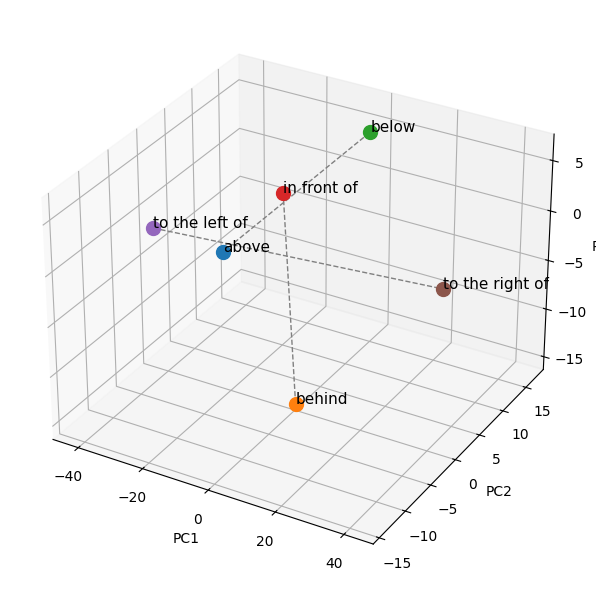

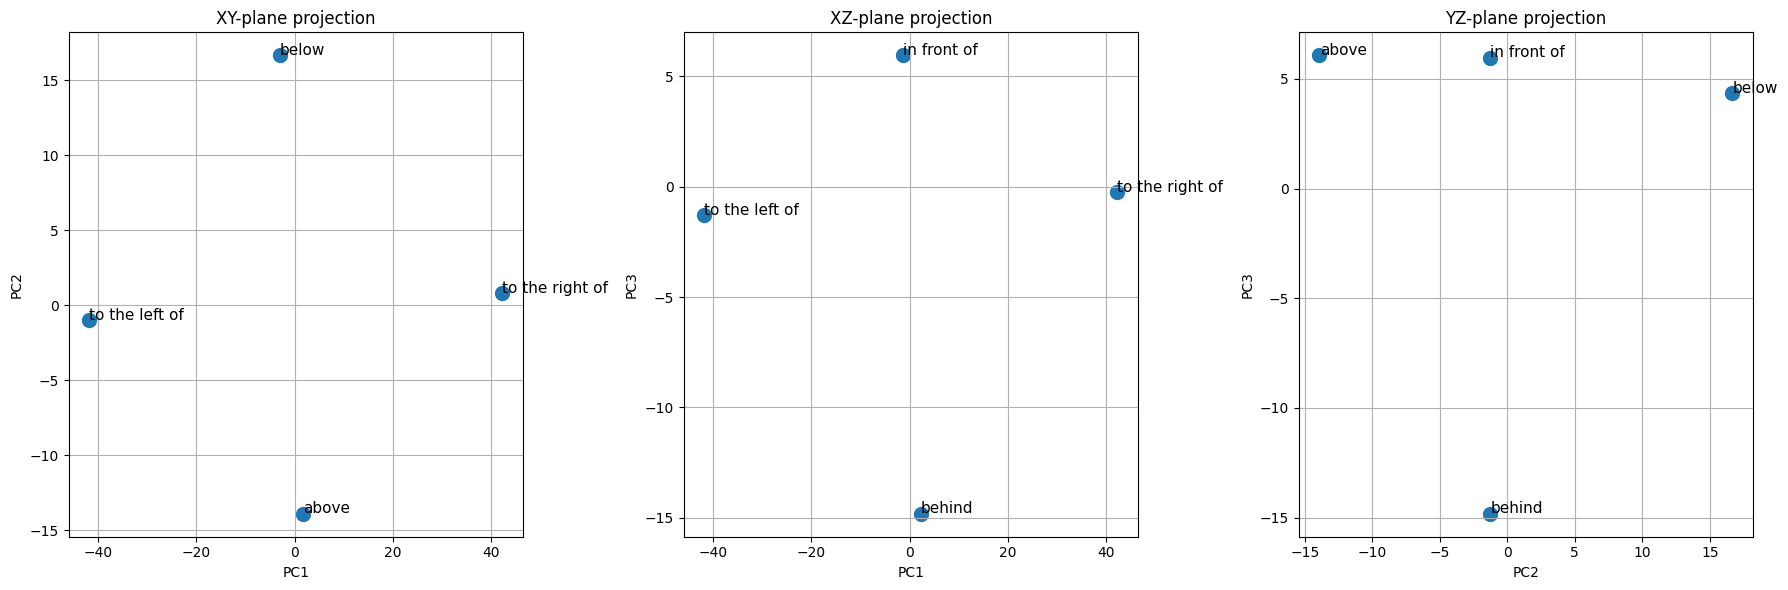


🧭 PCA Inverse Pair: 'above' ↔ 'below'
  PCA Cosine Similarity: 0.7889
  PCA Angle: 37.92°

🧭 PCA Inverse Pair: 'to the left of' ↔ 'to the right of'
  PCA Cosine Similarity: 0.9993
  PCA Angle: 2.12°

🧭 PCA Inverse Pair: 'in front of' ↔ 'behind'
  PCA Cosine Similarity: 0.9554
  PCA Angle: 17.18°

inverse relation analysis for layer 24...

🔁 Inverse Pair: 'above' ↔ 'below'
  Cosine Similarity: 0.4449
  Angle: 63.58°

🔁 Inverse Pair: 'to the left of' ↔ 'to the right of'
  Cosine Similarity: 0.9640
  Angle: 15.42°

🔁 Inverse Pair: 'in front of' ↔ 'behind'
  Cosine Similarity: 0.1137
  Angle: 83.47°

📊 Inverse Relation Metrics Summary
|    | Relation 1     | Relation 2 (Inverse)   |   Cosine Similarity |   Euclidean Distance |   Angle (°) |
|----|----------------|------------------------|---------------------|----------------------|-------------|
|  0 | above          | below                  |              0.4449 |              24.3855 |     63.5800 |
|  1 | to the left of | to the right

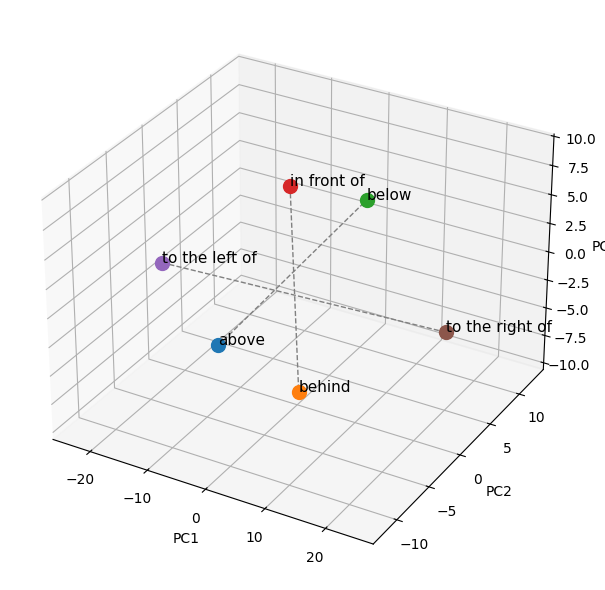

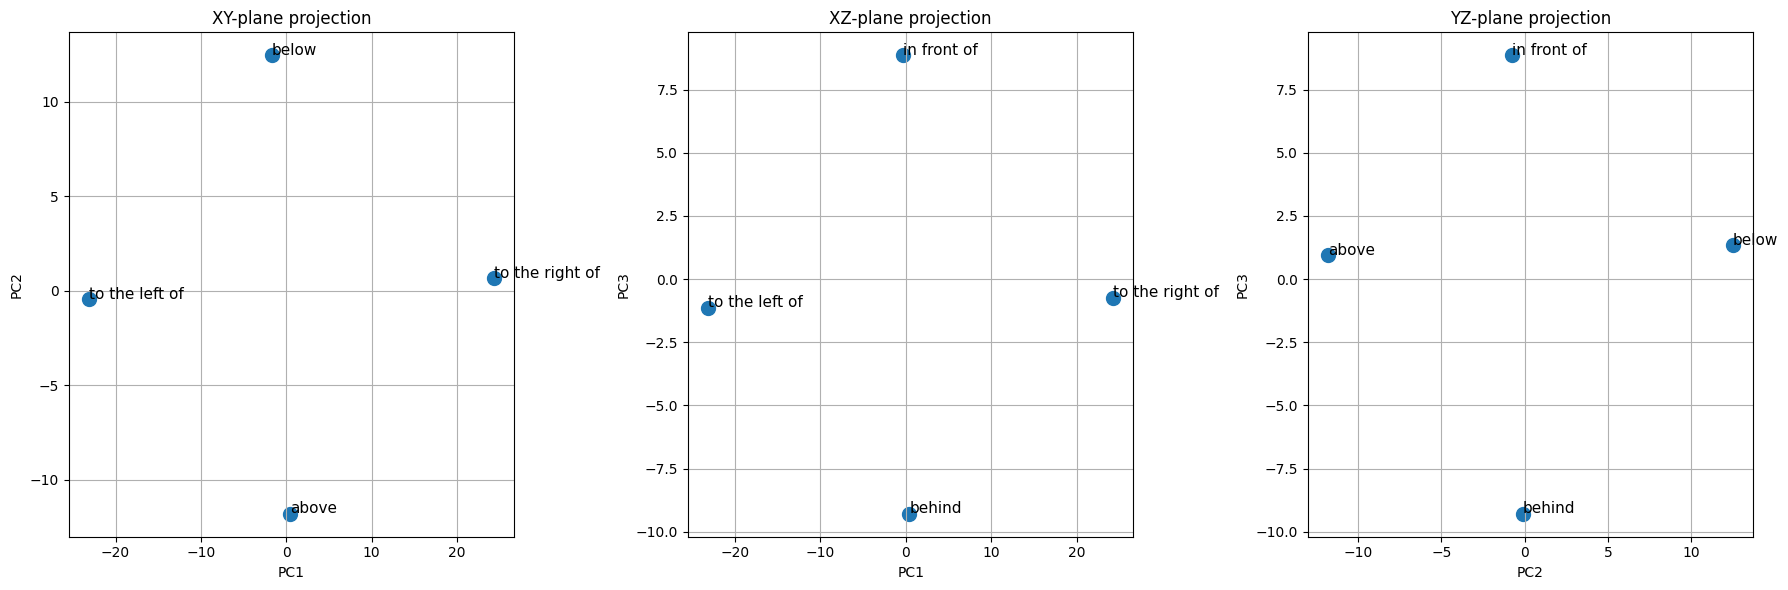


🧭 PCA Inverse Pair: 'above' ↔ 'below'
  PCA Cosine Similarity: 0.9779
  PCA Angle: 12.08°

🧭 PCA Inverse Pair: 'to the left of' ↔ 'to the right of'
  PCA Cosine Similarity: 0.9969
  PCA Angle: 4.55°

🧭 PCA Inverse Pair: 'in front of' ↔ 'behind'
  PCA Cosine Similarity: 0.9949
  PCA Angle: 5.76°


In [ ]:
# check directions' properties
directions_df = {}

for k in layers_list:
    layer_name = f"layer_{k}"
    print(f"\ninverse relation analysis for layer {k}...")
    directions_df[layer_name] = check_inverse_relations(directions[layer_name])